# Project: Section 4 | Classification | Creditworthiness

## Course: Business Analyst Nanodegree
## Student: Peter Jones
## Date: 2018.04.09

----

## Step 1: Business understanding

### What decision needs to be made?
The decision to be made here is to determine how many creditworthy customers exist in a list of new loan applications.

### What data is needed to make this decision?
To build a model to assist in making this decision, data is needed on as many past loan approvals as possible, with as mmuch data on the customers as is feasible to collect and the outcome of whether the customer ended up being creditworthy or not.

### What kind of model (Continuous, Binary, Non-Binary, Time-Series) do we need to use to help make these decisions?
The outcome variable for these data is a binary value of creditworthy or not, so we would create binary models to help make this decision.

## Step 2: Building the training set

In [1]:
df.train.raw <- readxl::read_excel( '../data/classification//credit-data-training.xlsx' )
df.test.raw <- readxl::read_excel( '../data/classification/customers-to-score.xlsx')

In [2]:
names( df.train.raw ) <- c( "application_result_txt"
                           , "acct_balance_txt"
                           , "months_of_credit_no"
                           , "prev_payment_status_txt"
                           , "purpose_txt"
                           , "credit_amt_no"
                           , "savings_stocks_val_no"
                           , "curr_employment_length_no"
                           , "installment_perc_no"
                           , "guarantors_txt"
                           , "curr_address_dur_no"
                           , "most_val_asset_cd"
                           , "age_no"
                           , "concurrent_credits_txt"
                           , "apartment_type_txt"
                           , "credits_at_bank_no"
                           , "occupation_txt"
                           , "dependents_no"
                           , "telephone_txt"
                           , "foreign_worker_flg" )

In [3]:
df.train.raw <- transform(  df.train.raw
                          , application_result_txt = factor( application_result_txt ) 
                          , acct_balance_txt = factor( acct_balance_txt )
                          , months_of_credit_no = months_of_credit_no
                          , prev_payment_status_txt = factor( prev_payment_status_txt )
                          , purpose_txt = factor( purpose_txt )
                          , credit_amt_no = credit_amt_no
                          , savings_stocks_val_no = factor( savings_stocks_val_no )
                          , curr_employment_length_no = factor( curr_employment_length_no )
                          , installment_perc_no = installment_perc_no
                          , guarantors_txt = factor( guarantors_txt )
                          , curr_address_dur_no = curr_address_dur_no
                          , most_val_asset_cd = factor( most_val_asset_cd )
                          , age_no = age_no
                          , concurrent_credits_txt = factor( concurrent_credits_txt )
                          , apartment_type_txt = factor( apartment_type_txt )
                          , credits_at_bank_no = factor( credits_at_bank_no )
                          , occupation_txt = factor( occupation_txt )
                          , dependents_no = dependents_no
                          , telephone_txt = factor( telephone_txt )
                          , foreign_worker_flg = factor( foreign_worker_flg )
                         )

In [4]:
facvar <- c( "application_result_txt"
           , "acct_balance_txt"
           , "prev_payment_status_txt"
           , "purpose_txt"
           , "savings_stocks_val_no"
           , "curr_employment_length_no"
           , "guarantors_txt"
           , "most_val_asset_cd"
           , "concurrent_credits_txt"
           , "apartment_type_txt"
           , "credits_at_bank_no"
           , "occupation_txt"
           , "telephone_txt"
           , "foreign_worker_flg" )

In [5]:
convar <- c( "months_of_credit_no"
           , "credit_amt_no"
           , "installment_perc_no"
           , "curr_address_dur_no"
           , "age_no"
           , "dependents_no" )

### Are any of your numerical data fields highly-correlated with each other?

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend



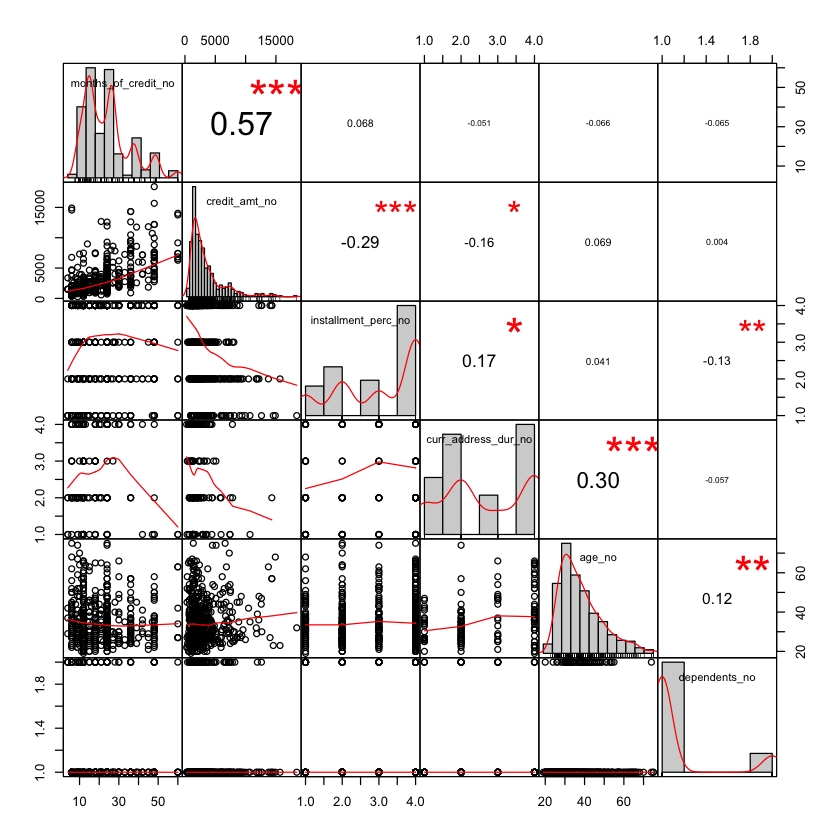

In [6]:
library( PerformanceAnalytics )
chart.Correlation( df.train.raw[,convar])

#### No variables reach the .7 threshold of being highly correlated, so all retained.

### Are there any missing data for each of the data fields?

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2018 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


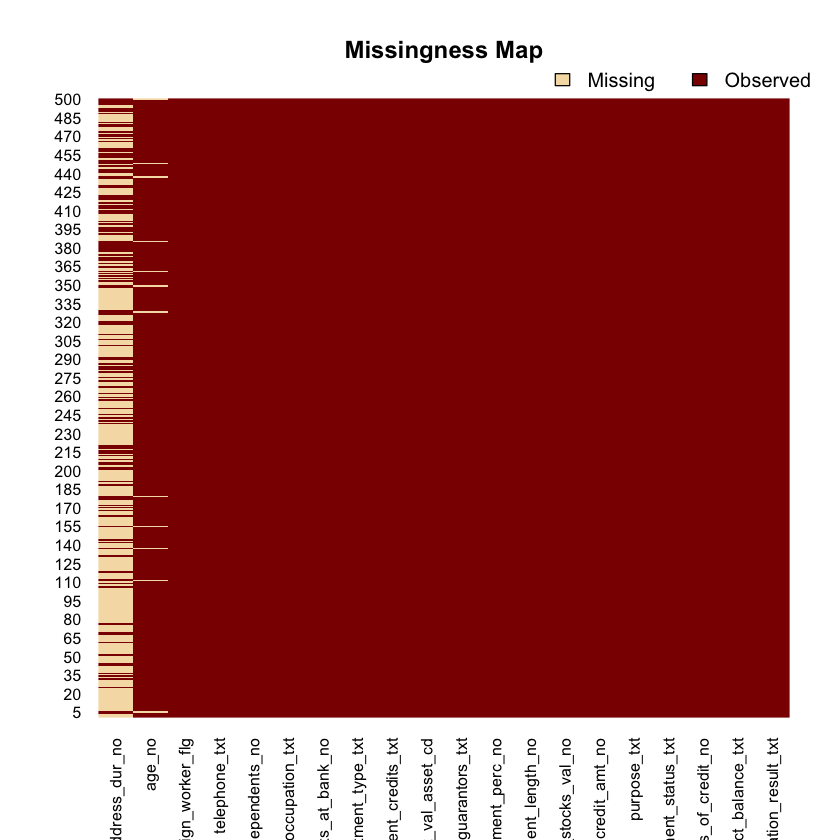

In [7]:
library( Amelia )
missmap( df.train.raw )

#### Removing address_dur_no due to missingness.

In [8]:
library( tidyverse )

df.train.raw <- select( df.train.raw, -curr_address_dur_no )

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::last()   masks xts::last()


#### Impute missing values for age_no as median

In [9]:
df.train.raw[is.na( df.train.raw$age_no ),]$age_no <- median( df.train.raw$age_no, na.rm = TRUE )

### Are there only a few values in a subset of your data field? Does the data field look very uniform (there is only one value for the entire field?).

In [10]:
library( reshape2 )
fac.check <- melt( df.train.raw[,facvar], 1 )


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Warning message:
“attributes are not identical across measure variables; they will be dropped”

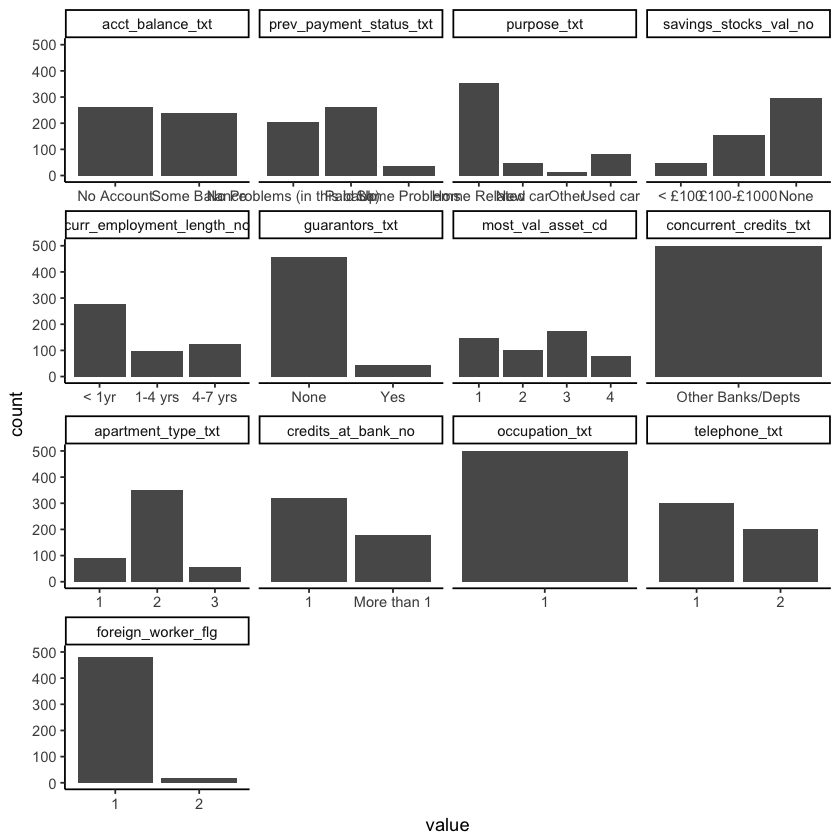

In [11]:
ggplot( fac.check, aes( x = value ) ) +
    geom_bar() +
    facet_wrap( ~variable, scales = "free_x" ) +
    theme_classic()

Removing occupation_txt, concurrent_credits_txt, guarantors_txt, and foreign_worker_flg due to low variablility.

In [12]:
df.train.raw <- df.train.raw %>%
    select( -occupation_txt ) %>%
    select( -concurrent_credits_txt ) %>%
    select( -guarantors_txt ) %>%
    select( -foreign_worker_flg )

### Checking age value against the course information

In [13]:
round( mean( df.train.raw$age_no, na.rm = TRUE ) )

[1] 36

#### Data looks clean, though I have 15 columns where the course information says to have 13.

## Step 3: Train classification models

### Create training and validation sets

In [14]:
library( caret )

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [15]:
set.seed( 1 )

In [16]:
train <- createDataPartition( df.train.raw$application_result_txt
                             , times = 1
                             , p = 0.7
                             , list = FALSE )

In [17]:
df.train <- df.train.raw[train,]

In [18]:
df.val <- df.train.raw[-train,]

### Logistic regression

### TODO: Need to fix this logistic regression model, only 25% accuracy

In [19]:
fit.glm.full <- glm( application_result_txt
              ~ .
              , data = df.train
              , family = binomial )

In [20]:
summary( fit.glm.full )


Call:
glm(formula = application_result_txt ~ ., family = binomial, 
    data = df.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9043  -0.7365  -0.4670   0.7198   2.3250  

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -3.719e+00  1.057e+00  -3.520 0.000432 ***
acct_balance_txtSome Balance         -1.325e+00  3.190e-01  -4.152 3.29e-05 ***
months_of_credit_no                   8.341e-03  1.383e-02   0.603 0.546448    
prev_payment_status_txtPaid Up        4.149e-01  4.078e-01   1.017 0.308917    
prev_payment_status_txtSome Problems  1.534e+00  5.621e-01   2.728 0.006368 ** 
purpose_txtNew car                   -1.632e+00  6.094e-01  -2.677 0.007421 ** 
purpose_txtOther                     -1.077e+00  9.387e-01  -1.148 0.251153    
purpose_txtUsed car                  -6.820e-01  4.026e-01  -1.694 0.090260 .  
credit_amt_no                         1.447e-04  7.194e-05   

In [21]:
fit.glm.red <- glm( application_result_txt
              ~ acct_balance_txt
              + prev_payment_status_txt
                + purpose_txt
                + credit_amt_no
                + installment_perc_no
                + most_val_asset_cd
              , data = df.train
              , family = binomial )

In [22]:
options( scipen = 10)
summary( fit.glm.red )


Call:
glm(formula = application_result_txt ~ acct_balance_txt + prev_payment_status_txt + 
    purpose_txt + credit_amt_no + installment_perc_no + most_val_asset_cd, 
    family = binomial, data = df.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0802  -0.7411  -0.4996   0.7425   2.3685  

Coefficients:
                                        Estimate  Std. Error z value   Pr(>|z|)
(Intercept)                          -2.57344075  0.60367899  -4.263 0.00002018
acct_balance_txtSome Balance         -1.34361665  0.29711854  -4.522 0.00000612
prev_payment_status_txtPaid Up        0.25427137  0.29511946   0.862    0.38891
prev_payment_status_txtSome Problems  1.43514840  0.52784569   2.719    0.00655
purpose_txtNew car                   -1.51435766  0.58175349  -2.603    0.00924
purpose_txtOther                     -1.07142241  0.92569724  -1.157    0.24710
purpose_txtUsed car                  -0.57071910  0.38178626  -1.495    0.13495
credit_amt_no          

In [23]:
df.val$pred <- predict( fit.glm.red
                       , df.val
                       , type = 'response' )

In [24]:
df.val<- within( df.val, {
    pred[pred >= 0.5] = 'Creditworthy'
    pred[pred< 0.5] = 'Non-Creditworthy'
})

In [25]:
confusionMatrix( df.val$application_result_txt
                , df.val$pred )

Confusion Matrix and Statistics

                  Reference
Prediction         Creditworthy Non-Creditworthy
  Creditworthy                8               99
  Non-Creditworthy           12               30
                                          
               Accuracy : 0.255           
                 95% CI : (0.1872, 0.3328)
    No Information Rate : 0.8658          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : -0.1295         
 Mcnemar's Test P-Value : 3.275e-16       
                                          
            Sensitivity : 0.40000         
            Specificity : 0.23256         
         Pos Pred Value : 0.07477         
         Neg Pred Value : 0.71429         
             Prevalence : 0.13423         
         Detection Rate : 0.05369         
   Detection Prevalence : 0.71812         
      Balanced Accuracy : 0.31628         
                                          
       'Positive' 

### Decision tree model

In [26]:
library( rpart )
fit.dt <- rpart( application_result_txt 
     ~ .
     , data = df.train )

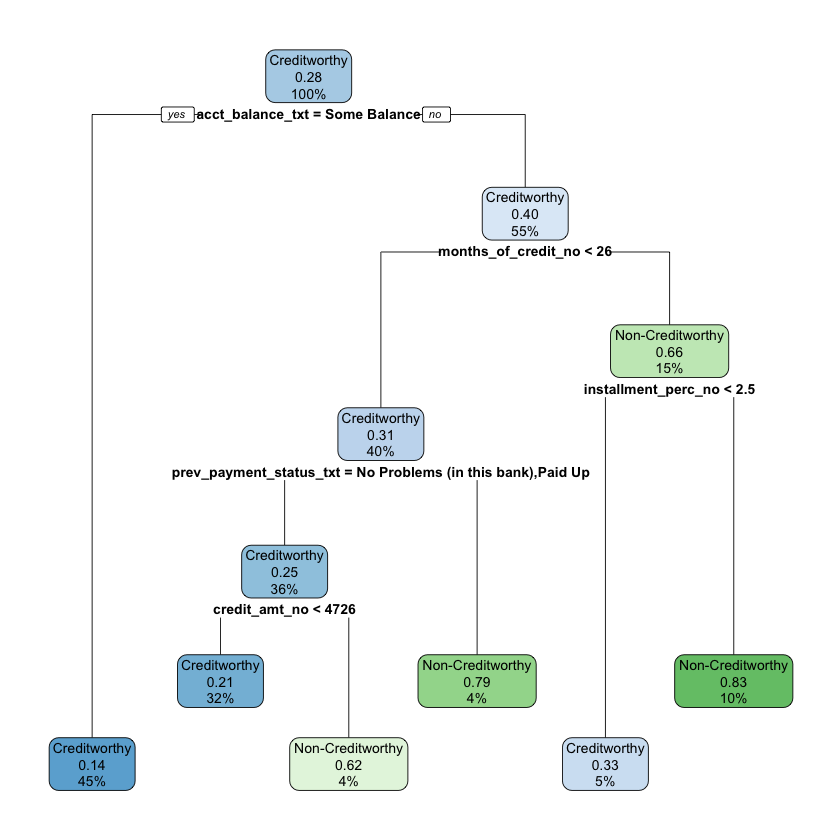

In [27]:
library( rpart.plot )
rpart.plot( fit.dt )

In [64]:
summary( fit.dt )

Call:
rpart(formula = application_result_txt ~ ., data = df.train)
  n= 351 

     CP nsplit rel error xerror       xstd
1 0.085      0      1.00   1.00 0.08456357
2 0.080      2      0.83   0.97 0.08378170
3 0.060      3      0.75   0.83 0.07960730
4 0.030      4      0.69   0.76 0.07716486
5 0.010      5      0.66   0.73 0.07603793

Variable importance
         acct_balance_txt       months_of_credit_no             credit_amt_no 
                       22                        18                        16 
  prev_payment_status_txt       installment_perc_no     savings_stocks_val_no 
                       15                        11                         8 
        most_val_asset_cd                    age_no curr_employment_length_no 
                        3                         2                         2 
       apartment_type_txt               purpose_txt 
                        2                         1 

Node number 1: 351 observations,    complexity param=0.085
  p

In [28]:
df.val$pred <- predict( fit.dt
       , df.val
       , type = 'class')

In [30]:
confusionMatrix( df.val$application_result_txt
               , df.val$pred )

Confusion Matrix and Statistics

                  Reference
Prediction         Creditworthy Non-Creditworthy
  Creditworthy               97               10
  Non-Creditworthy           30               12
                                          
               Accuracy : 0.7315          
                 95% CI : (0.6529, 0.8008)
    No Information Rate : 0.8523          
    P-Value [Acc > NIR] : 0.999958        
                                          
                  Kappa : 0.2248          
 Mcnemar's Test P-Value : 0.002663        
                                          
            Sensitivity : 0.7638          
            Specificity : 0.5455          
         Pos Pred Value : 0.9065          
         Neg Pred Value : 0.2857          
             Prevalence : 0.8523          
         Detection Rate : 0.6510          
   Detection Prevalence : 0.7181          
      Balanced Accuracy : 0.6546          
                                          
       'Positive' 

### Forest model

In [32]:
library(randomForest)

Warning message:
“package ‘randomForest’ was built under R version 3.4.4”randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [34]:
fit.rf <- randomForest( application_result_txt
            ~ .
            , data = df.train )

In [36]:
library( reprtree )

Loading required package: tree
Warning message:
“package ‘tree’ was built under R version 3.4.4”Loading required package: plotrix


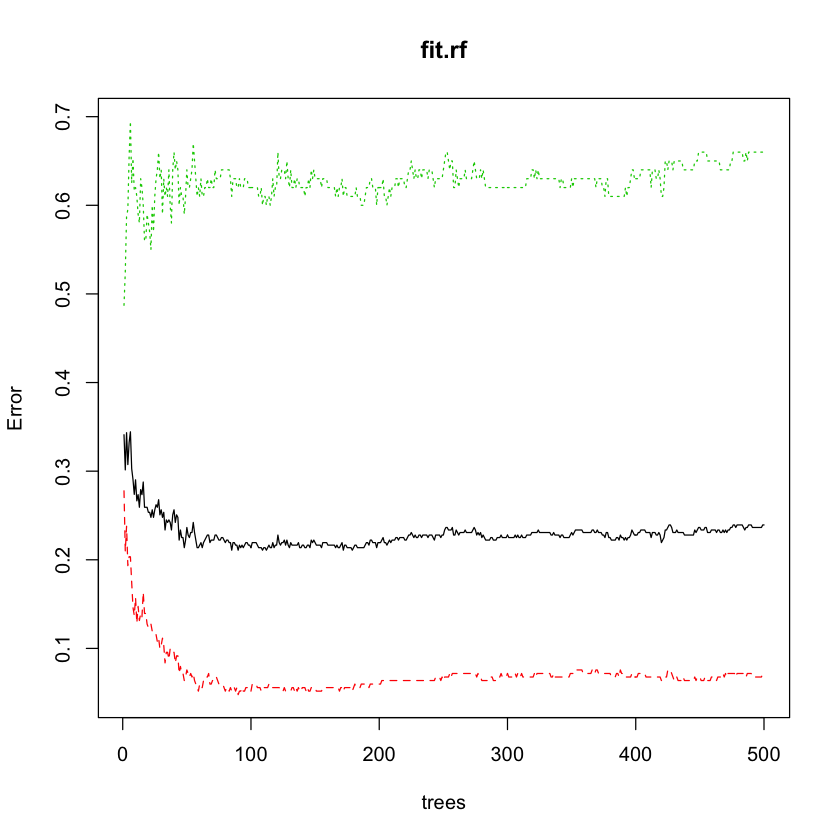

In [40]:
plot( fit.rf )

In [43]:
df.val$pred <- predict( fit.rf
       , df.val )

In [44]:
confusionMatrix( df.val$application_result_txt
               , df.val$pred )

Confusion Matrix and Statistics

                  Reference
Prediction         Creditworthy Non-Creditworthy
  Creditworthy              102                5
  Non-Creditworthy           25               17
                                          
               Accuracy : 0.7987          
                 95% CI : (0.7252, 0.8598)
    No Information Rate : 0.8523          
    P-Value [Acc > NIR] : 0.9711810       
                                          
                  Kappa : 0.4186          
 Mcnemar's Test P-Value : 0.0005226       
                                          
            Sensitivity : 0.8031          
            Specificity : 0.7727          
         Pos Pred Value : 0.9533          
         Neg Pred Value : 0.4048          
             Prevalence : 0.8523          
         Detection Rate : 0.6846          
   Detection Prevalence : 0.7181          
      Balanced Accuracy : 0.7879          
                                          
       'Positive' 

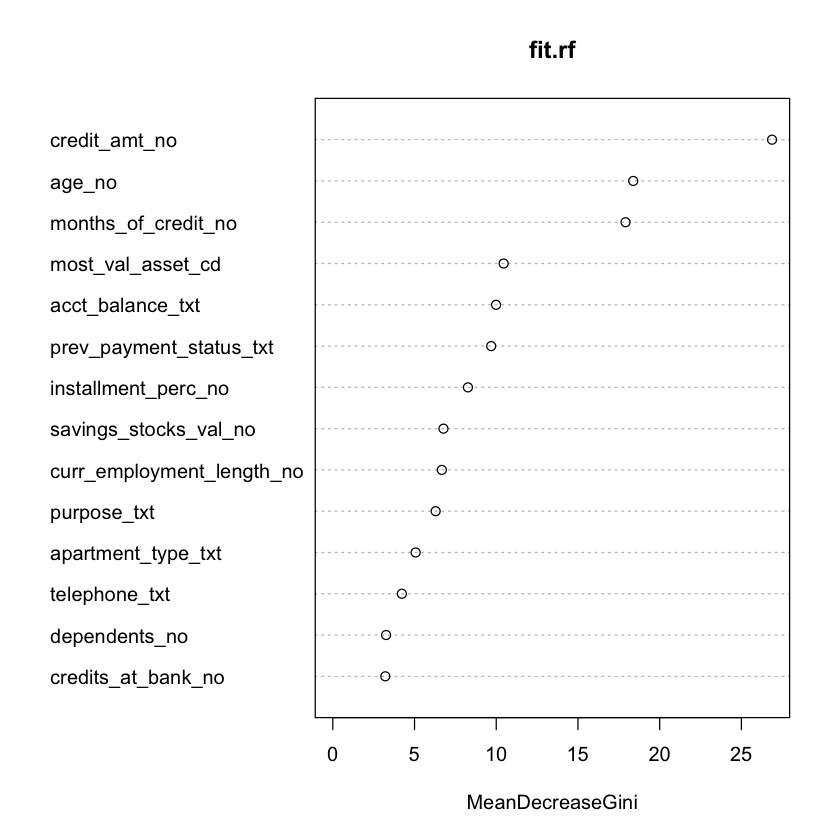

In [60]:
varImpPlot( fit.rf )

### Boosted tree model

In [46]:
library( gbm )

Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:caret’:

    cluster

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


In [52]:
fit.bm <- gbm( as.numeric( application_result_txt ) - 1
             ~ .
             , data = df.train
             , distribution = 'bernoulli' )

In [74]:
df.val$pred <- predict.gbm( fit.bm
       , df.val
        , n.trees = 100
        , type = 'response' )

,var,rel.inf
acct_balance_txt,acct_balance_txt,65.1615439
prev_payment_status_txt,prev_payment_status_txt,13.3014060
months_of_credit_no,months_of_credit_no,12.3628671
credit_amt_no,credit_amt_no,7.9918132
most_val_asset_cd,most_val_asset_cd,0.6562320
savings_stocks_val_no,savings_stocks_val_no,0.5261377
purpose_txt,purpose_txt,0.0000000
curr_employment_length_no,curr_employment_length_no,0.0000000
installment_perc_no,installment_perc_no,0.0000000
age_no,age_no,0.0000000


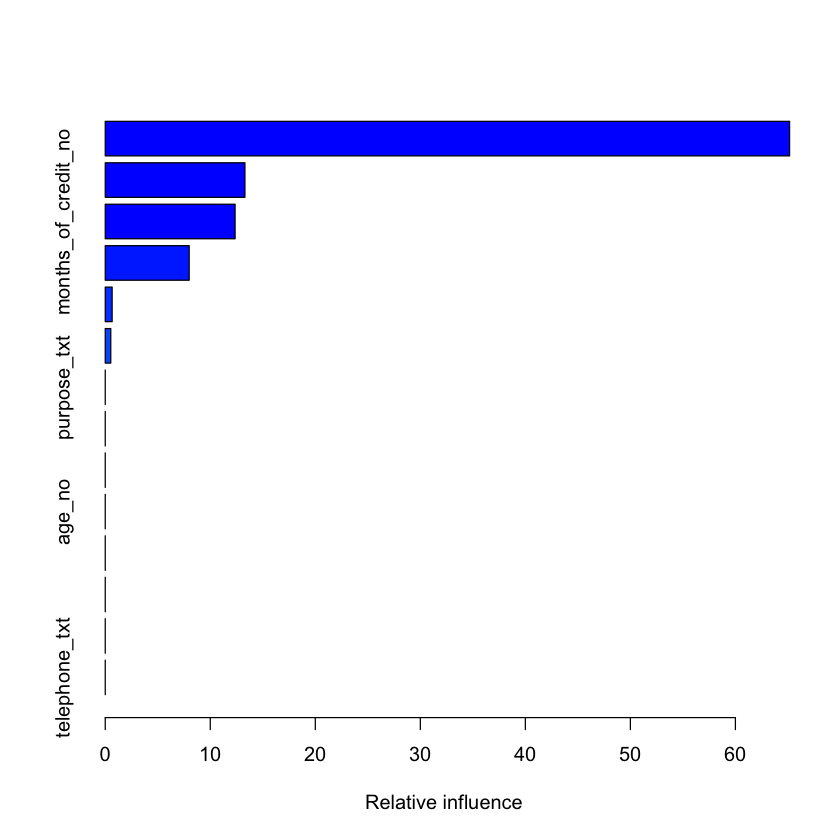

In [57]:
summary( fit.bm )

In [75]:
confusionMatrix( df.val$application_result_txt
               , df.val$pred )

ERROR: Error in confusionMatrix.default(df.val$application_result_txt, df.val$pred): The data must contain some levels that overlap the reference.


### Compare the 4 models

In [67]:
anova( fit.glm.red
     , fit.dt
     , fit.rf
     , fit.bm )

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,350,419.4605
acct_balance_txt,1,31.511036,349,387.9495
prev_payment_status_txt,2,10.742141,347,377.2073
purpose_txt,3,8.032664,344,369.1747
credit_amt_no,1,10.449533,343,358.7251
installment_perc_no,1,9.743170,342,348.9820
most_val_asset_cd,3,6.075229,339,342.9067
